In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ff

def interpolate_dataset(data, extend=0, poly_order=1):
    """
    Interpolate a dataset of (x,y) pairs, where x are integers, using polynomial interpolation.
    
    Args:
        data: List of (x,y) tuples where x are integers
        extend: Number of points to extend beyond max(x)
        poly_order: Order of the polynomial to use for interpolation (1=linear, 2=quadratic, etc.)
                    Will automatically reduce order if not enough points are available
    
    Returns:
        List of (x,y) tuples with interpolated and extended values
    """
    # Sort data by x values
    sorted_data = sorted(data, key=lambda point: point[0])
    
    # Extract x and y values
    x_values = [point[0] for point in sorted_data]
    y_values = [point[1] for point in sorted_data]
    
    # Find min and max x values
    min_x = min(x_values)
    max_x = max(x_values)
    
    # Create a dictionary from original data for easy lookup
    data_dict = {x: y for x, y in sorted_data}
    
    # Ensure we have enough points for the polynomial order
    actual_poly_order = min(poly_order, len(sorted_data) - 1)
    if actual_poly_order != poly_order:
        print(f"Warning: Reduced polynomial order from {poly_order} to {actual_poly_order} due to insufficient data points")
    
    result = []
    
    # If we have enough points for polynomial interpolation
    if len(sorted_data) > 1:
        if actual_poly_order == 1:
            # Linear interpolation (original method)
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    result.append((x, data_dict[x]))
                else:
                    # Find closest points before and after x
                    left_idx = 0
                    while left_idx < len(x_values) - 1 and x_values[left_idx + 1] <= x:
                        left_idx += 1
                    
                    right_idx = len(x_values) - 1
                    while right_idx > 0 and x_values[right_idx - 1] >= x:
                        right_idx -= 1
                    
                    # Interpolate y value
                    x1, y1 = x_values[left_idx], y_values[left_idx]
                    x2, y2 = x_values[right_idx], y_values[right_idx]
                    
                    y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                    result.append((x, y))
        else:
            # Polynomial interpolation
            coeffs = np.polyfit(x_values, y_values, actual_poly_order)
            
            # Interpolate for all integer points
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    # Use original data point if available
                    result.append((x, data_dict[x]))
                else:
                    # Use polynomial to interpolate
                    y = np.polyval(coeffs, x)
                    result.append((x, y))
    else:
        # Just one point, can't interpolate
        result = sorted_data.copy()
    
    # Extend beyond max_x if requested (always using linear extension)
    if extend > 0 and len(x_values) >= 2:
        # Get the last two points to determine the slope for extension
        second_to_last_x = x_values[-2]
        second_to_last_y = y_values[-2]
        last_x = x_values[-1]
        last_y = y_values[-1]
        
        # Calculate slope
        slope = (last_y - second_to_last_y) / (last_x - second_to_last_x)
        
        # Add extended points
        for i in range(1, extend + 1):
            x = max_x + i
            y = last_y + slope * i
            result.append((x, y))
    
    return result


# Path to the transmitted power file
file_path = '../logs/central-dep-concluded-double-v2/transmitted_power.txt'

# Initialize empty lists for wavelengths and transmitted power values
wavelengths = []
transmitted_power = []

# Read the file and extract the values
with open(file_path, 'r') as f:
    for line in f:
        # Split the line by colon and extract values
        parts = line.strip().split(': ')
        if len(parts) == 2:
            wavelength = float(parts[0])
            power = float(parts[1])
            wavelengths.append(wavelength)
            transmitted_power.append(power)

# Convert lists to numpy arrays for easier manipulation
wavelengths = np.round(np.array(wavelengths)*1000)
transmitted_power = np.array(transmitted_power)

# Print the first few values to verify
print(f"Loaded {len(wavelengths)} data points")
print("First 5 wavelengths:", wavelengths[:5])
print("First 5 transmitted power values:", transmitted_power[:5])
wavelengths = torch.tensor(wavelengths)

data = [(int(wavelengths[i].item()), transmitted_power[i]) for i in range(len(wavelengths))]
print(data)
interpolated_data = interpolate_dataset(data, extend=0, poly_order=1)
interpolated_ppw = torch.tensor([i[1] for i in interpolated_data])
wavelengths = torch.linspace(.350, 3, 2651)
print(len(wavelengths),len(interpolated_ppw))
bandgaps = [.5, .6, .61, .62, .63, .64, .65, .66, .67, .68, .69, .7, .71, .72, .726, .8, .9, 1]

FOMs = []

for bandgap in bandgaps:
    FOMs.append(ff.power_ratio(wavelengths, torch.tensor(interpolated_ppw), ff.T_e, bandgap).item())
    print(f"Bandgap: {bandgap}, FOM: {FOMs[-1]}")

Loaded 531 data points
First 5 wavelengths: [350. 355. 360. 365. 370.]
First 5 transmitted power values: [0.55704925 0.53262582 0.55173869 0.61581208 0.74031547]
[(350, np.float64(0.557049250082932)), (355, np.float64(0.5326258160496036)), (360, np.float64(0.5517386909704203)), (365, np.float64(0.6158120762579278)), (370, np.float64(0.7403154688878706)), (375, np.float64(0.8465996686048353)), (380, np.float64(0.919082166377995)), (385, np.float64(0.9467914931936015)), (390, np.float64(0.9078852966171594)), (395, np.float64(0.8209913549418624)), (400, np.float64(0.7323075307767493)), (405, np.float64(0.6612240410264474)), (410, np.float64(0.612408694803468)), (415, np.float64(0.5830266885665749)), (420, np.float64(0.5687774271906141)), (425, np.float64(0.567922065461614)), (430, np.float64(0.5812331158934315)), (435, np.float64(0.6100059685423926)), (440, np.float64(0.6544514837053415)), (445, np.float64(0.7123774450006828)), (450, np.float64(0.7772075648768951)), (455, np.float64(0.839

/tmp/ipykernel_237572/181393424.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  FOMs.append(ff.power_ratio(wavelengths, torch.tensor(interpolated_ppw), ff.T_e, bandgap).item())
/home/rliacobacci/tpv-shaping/trials/ff.py:377: RuntimeWarning: overflow encountered in exp
  return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8


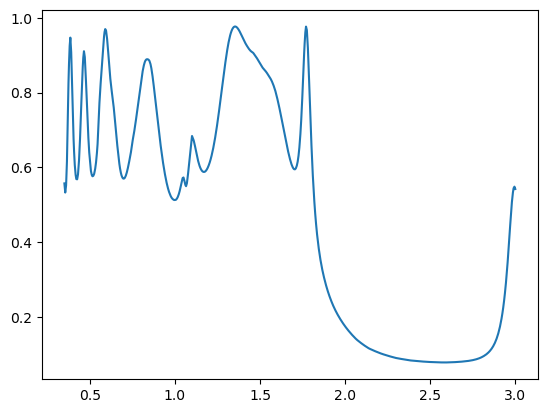

In [17]:
plt.plot(wavelengths.numpy(), interpolated_ppw)